In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import prince
import plotly.io as pio
import plotly.graph_objects as go

# Análise de Correspondência Simples (ANACOR)

In [2]:
gestao = pd.read_excel("data/gestao_municipal.xlsx")

### Ao longo de 3 anos, foi aplicado questionário com a seguinte afirmação:
- Estou satisfeito com a gestão do atual prefeito!

*Respostas em escala likert de 5 pontos*

In [4]:
# Informações descritivas sobre as variáveis

print(gestao['avaliacao'].value_counts(), "\n")
print(gestao['ano'].value_counts())

avaliacao
Nem Concordo, Nem Discordo    2970
Concordo Parcialmente         2062
Discordo Parcialmente         2004
Discordo Totalmente            998
Concordo Totalmente            966
Name: count, dtype: int64 

ano
20X1    3000
20X2    3000
20X3    3000
Name: count, dtype: int64


In [5]:
# Criando a tabela de contingência

tabela = pd.crosstab(gestao["avaliacao"], gestao["ano"])

print(tabela)

ano                         20X1  20X2  20X3
avaliacao                                   
Concordo Parcialmente       1066   996     0
Concordo Totalmente          966     0     0
Discordo Parcialmente          1   998  1005
Discordo Totalmente            0     1   997
Nem Concordo, Nem Discordo   967  1005   998


In [6]:
# Analisando a significância estatística da associação (teste qui²)

teste_qui2 = chi2_contingency(tabela)

print(f"estatística qui²: {round(teste_qui2[0], 2)}")
print(f"p-valor da estatística: {round(teste_qui2[1], 4)}")
print(f"graus de liberdade: {teste_qui2[2]}")

estatística qui²: 5956.44
p-valor da estatística: 0.0
graus de liberdade: 8


### Mapa de calor dos resíduos padronizados ajustados

In [7]:
# Tabela de contingência

tab_cont = sm.stats.Table(tabela)

In [8]:
# Gráfico dos resíduos padronizados ajustados

fig = go.Figure()

maxz = np.max(tab_cont.standardized_resids)+0.1
minz = np.min(tab_cont.standardized_resids)-0.1

colorscale = ['lightgreen' if i>1.96 else '#FAF9F6' for i in np.arange(minz,maxz,0.01)]

fig.add_trace(
    go.Heatmap(
        x = tab_cont.standardized_resids.columns,
        y = tab_cont.standardized_resids.index,
        z = np.array(tab_cont.standardized_resids),
        text=tab_cont.standardized_resids.values,
        texttemplate='%{text:.2f}',
        showscale=False,
        colorscale=colorscale))

fig.update_layout(
    title='Resíduos Padronizados Ajustados',
    height = 600,
    width = 600)

fig.show()

### Elaborando a ANACOR

In [9]:
# Na função, o input é a tabela de contingência criada antes!

ca = prince.CA().fit(tabela)

In [10]:
# Obtendo os eigenvalues

tabela_autovalores = ca.eigenvalues_summary

print(tabela_autovalores)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.503        75.96%                     75.96%
1              0.159        24.04%                    100.00%


**São gerados 'm' autovalores: m = mín(I-1,J-1)**

### Obtendo a inércia principal total

- É a soma dos eigenvalues (também é a divisão: estat. qui² / N)
- Quanto maior a inércia principal total, maior é a associação entre categorias

In [11]:
print(ca.total_inertia_)

0.6618261885878851


In [12]:
# Obtendo as coordenadas do mapa perceptual

# Coordenadas da variável em linha
print(ca.row_coordinates(tabela))

# Coordenadas da variável em coluna
print(ca.column_coordinates(tabela))

                                   0         1
avaliacao                                     
Concordo Parcialmente      -0.634071 -0.315726
Concordo Totalmente        -1.222708  0.710623
Discordo Parcialmente       0.612588 -0.351081
Discordo Totalmente         1.225539  0.701462
Nem Concordo, Nem Discordo  0.012753 -0.010750
             0         1
ano                     
20X1 -0.866950  0.283437
20X2 -0.002882 -0.564066
20X3  0.869832  0.280629


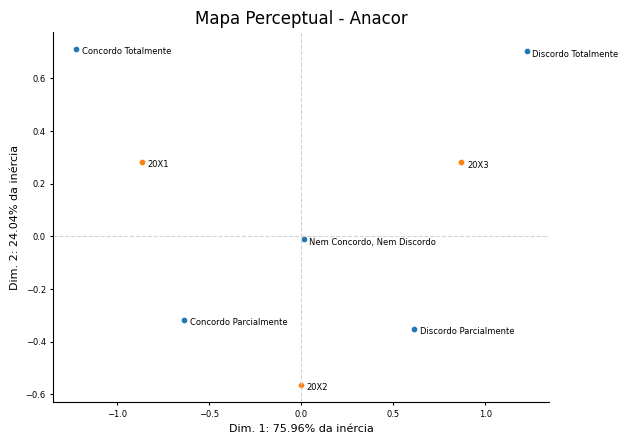

In [13]:
# Plotando o mapa percentual da Anacor

chart_df_row = pd.DataFrame({'var_row': tabela.index,
                             'x_row':ca.row_coordinates(tabela)[0].values,
                             'y_row': ca.row_coordinates(tabela)[1].values})

chart_df_col = pd.DataFrame({'var_col': tabela.columns,
                             'x_col':ca.column_coordinates(tabela)[0].values,
                             'y_col': ca.column_coordinates(tabela)[1].values})

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.03, point['y'] - 0.02, point['val'], fontsize=6)

label_point(x = chart_df_col['x_col'],
            y = chart_df_col['y_col'],
            val = chart_df_col['var_col'],
            ax = plt.gca())

label_point(x = chart_df_row['x_row'],
            y = chart_df_row['y_row'],
            val = chart_df_row['var_row'],
            ax = plt.gca()) 

sns.scatterplot(data=chart_df_row, x='x_row', y='y_row', s=20)
sns.scatterplot(data=chart_df_col, x='x_col', y='y_col', s=20)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.axhline(y=0, color='lightgrey', ls='--', linewidth=0.8)
plt.axvline(x=0, color='lightgrey', ls='--', linewidth=0.8)
plt.tick_params(size=2, labelsize=6)
plt.title("Mapa Perceptual - Anacor", fontsize=12)
plt.xlabel(f"Dim. 1: {tabela_autovalores.iloc[0,1]} da inércia", fontsize=8)
plt.ylabel(f"Dim. 2: {tabela_autovalores.iloc[1,1]} da inércia", fontsize=8)
plt.show()

In [14]:
# Obtendo as coordenadas das observações

# Identificando as variáveis em linha e em coluna
coord_obs = gestao.rename(columns={'avaliacao':'var_row',
                                   'ano':'var_col'})

# Unindo as coordenadas das categorias ao DataFrame
coord_obs = pd.merge(coord_obs, chart_df_row, how='left', on='var_row')
coord_obs = pd.merge(coord_obs, chart_df_col, how='left', on='var_col')

# Calculando as coordenadas médias das observações (média de suas categorias)
coord_obs['x_obs'] = coord_obs[['x_row','x_col']].mean(axis=1)
coord_obs['y_obs'] = coord_obs[['y_row','y_col']].mean(axis=1)